# README

## American Sign Language (ASL) Recognition

Este projeto utiliza redes neurais convolucionais (CNNs) — incluindo o modelo VGG16 — para realizar o reconhecimento de sinais do alfabeto ASL a partir de imagens. O notebook está baseado no dataset **ASL Alphabet** disponível no Kaggle.

## 📁 Estrutura do Projeto

```
Deep_e_IA_-_Mini-projeto_1_-_ASL.ipynb
```

## 📦 Requisitos

Antes de tudo, certifique-se de ter o Python 3.7+ instalado. Recomendamos o uso de um ambiente virtual.

Instale as dependências com:

```bash
pip install tensorflow keras matplotlib seaborn opencv-python imutils scikit-learn kagglehub
```

## 📥 Download do Dataset

Este projeto utiliza o dataset **ASL Alphabet** hospedado no Kaggle. Para baixá-lo:

1. Crie uma conta no [Kaggle](https://www.kaggle.com/)
2. Vá para [https://www.kaggle.com/datasets/grassknoted/asl-alphabet](https://www.kaggle.com/datasets/grassknoted/asl-alphabet)
3. O download é feito automaticamente pelo código usando:

```python
import kagglehub
grassknoted_asl_alphabet_path = kagglehub.dataset_download('grassknoted/asl-alphabet')
```

## ▶️ Como Executar

1. Abra o notebook:

```bash
jupyter notebook Deep_e_IA_-_Mini-projeto_1_-_ASL.ipynb
```

2. Execute as células em ordem. O processo inclui:

- Download e preparação dos dados
- Visualização de exemplos
- Treinamento do modelo CNN (VGG16, entre outros)
- Avaliação de métricas

⚠️ O tempo de execução pode variar dependendo da sua GPU/CPU.

## 📊 Resultados

Os principais resultados incluem:

- Acurácia de classificação por letra
- Matriz de confusão
- Visualizações das ativações usando Grad-CAM

## 🧠 Modelos Usados

- VGG16 com fine-tuning
- Camadas Dense customizadas
- Técnicas de Dropout

## 📌 Observações

- Idealmente executado em ambiente com GPU (ex: Google Colab)

## 🧐 Informações adicionais
### Equipe:
- Roberto Arruda: @rob-a-b  
- Julio Holanda: @JulioHolanda  
- Nicole Victory: @NicoleVictory  

## 📝 Licença
Este projeto está sob a licença MIT.

#1. | Preparação


In [ ]:
import kagglehub
grassknoted_asl_alphabet_path = kagglehub.dataset_download('grassknoted/asl-alphabet')

print('Data source import complete.')


Data source import complete.


In [ ]:
!pip install imutils

## import library

In [ ]:

import warnings
warnings.filterwarnings("ignore")

import os
import glob
import cv2
import numpy as np
import pandas as pd
import gc
import string
import time
import random
import imutils
from PIL import Image
from tqdm import tqdm
tqdm.pandas()

# Visualization
import matplotlib
import matplotlib.pyplot as plt
import plotly
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
from sklearn.manifold import TSNE

# Model
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten, Dropout
from keras.models import load_model, Model
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping

In [ ]:
# Configuration
class CFG:
    batch_size = 64
    img_height = 64
    img_width = 64
    epochs = 20
    num_classes = 29
    img_channels = 3

def seed_everything(seed: int):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

#2. | Dataset

## Exploração

In [ ]:
# Labels
TRAIN_PATH = "/kaggle/input/asl-alphabet/asl_alphabet_train/asl_alphabet_train"
labels = []
alphabet = list(string.ascii_uppercase)
labels.extend(alphabet)
labels.extend(["del", "nothing", "space"])
print(labels)

['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'del', 'nothing', 'space']


In [ ]:
def sample_images(labels):
    # Create Subplots
    y_size = 12
    if(len(labels)<10):
        y_size = y_size * len(labels) / 10
    fig, axs = plt.subplots(len(labels), 9, figsize=(y_size, 13))

    for i, label in enumerate(labels):
        axs[i, 0].text(0.5, 0.5, label, ha='center', va='center', fontsize=8)
        axs[i, 0].axis('off')

        label_path = os.path.join(TRAIN_PATH, label)
        list_files = os.listdir(label_path)

        for j in range(8):
            img_label = cv2.imread(os.path.join(label_path, list_files[j]))
            img_label = cv2.cvtColor(img_label, cv2.COLOR_BGR2RGB)
            axs[i, j+1].imshow(img_label)
            axs[i, j+1].axis("off")

    # Title
    plt.suptitle("Sample Images in ASL Alphabet Dataset", x=0.55, y=0.92)

    # Show
    plt.show()

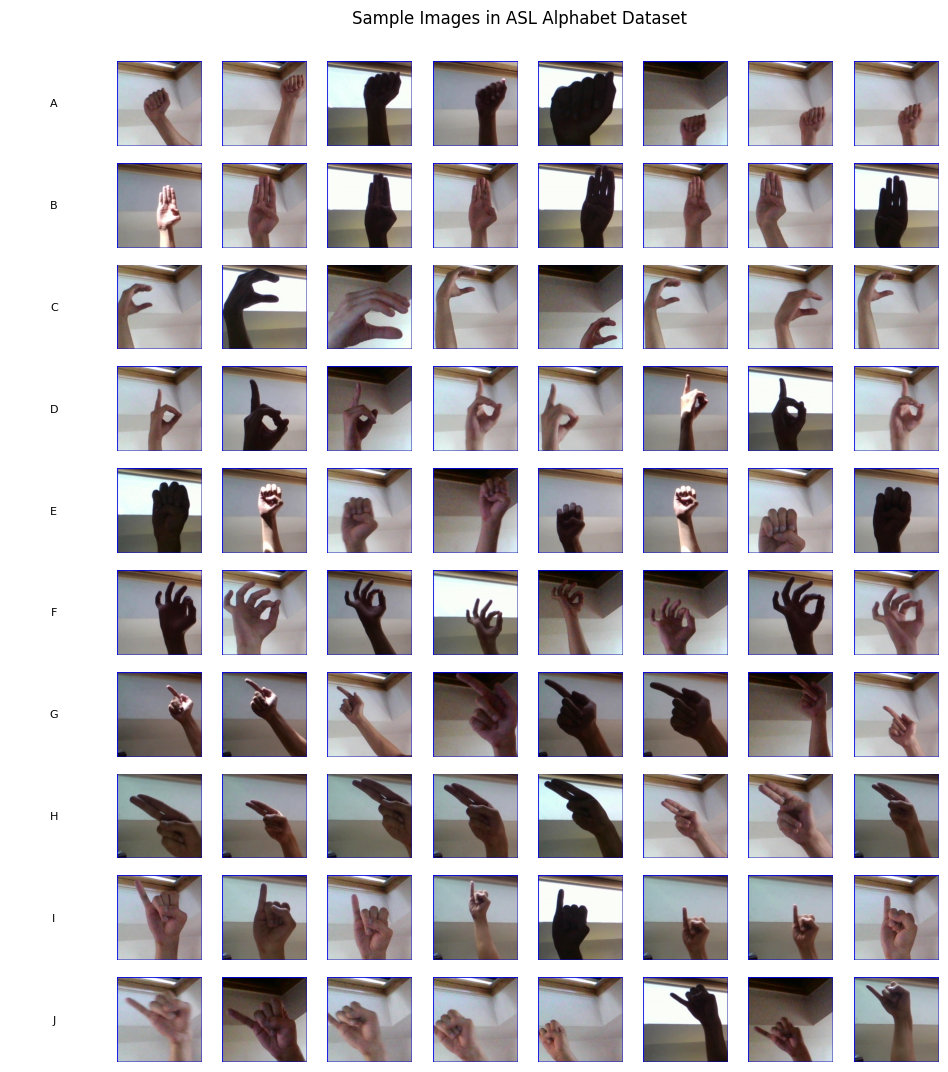

In [ ]:
sample_images(labels[:10])

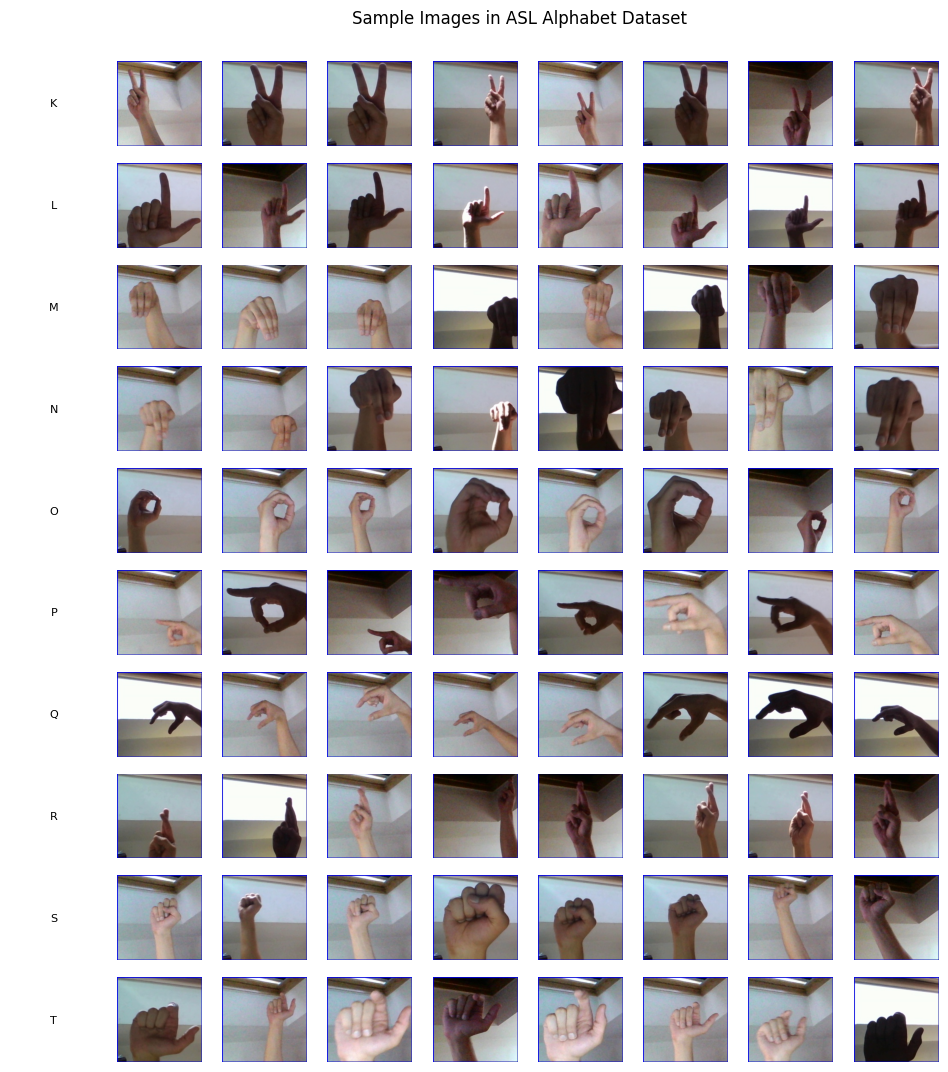

In [ ]:
sample_images(labels[10:20])

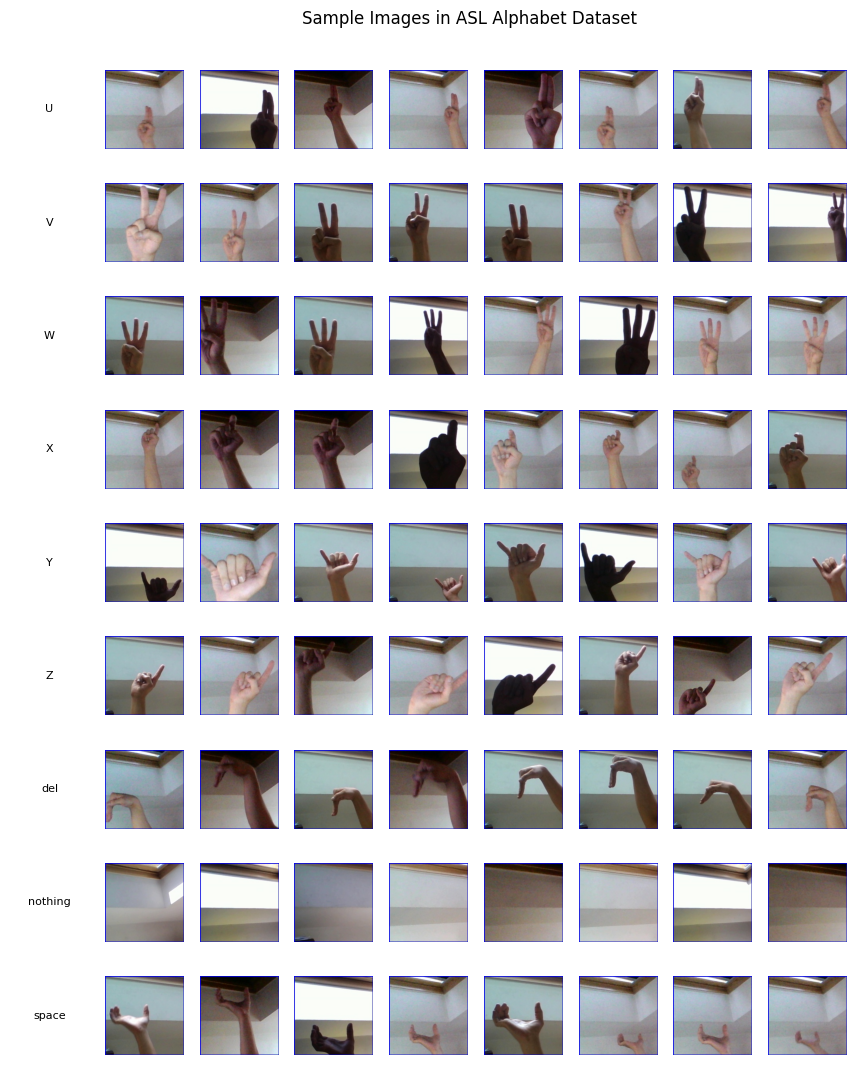

In [ ]:
sample_images(labels[20:])

## Processamento dos Dados

In [ ]:
# Create Metadata
list_path = []
list_labels = []
for label in labels:
    label_path = os.path.join(TRAIN_PATH, label, "*")
    image_files = glob.glob(label_path)

    sign_label = [label] * len(image_files)

    list_path.extend(image_files)
    list_labels.extend(sign_label)

metadata = pd.DataFrame({
    "image_path": list_path,
    "label": list_labels
})

metadata

image_path  label
0      /kaggle/input/asl-alphabet/asl_alphabet_train/...      A
1      /kaggle/input/asl-alphabet/asl_alphabet_train/...      A
2      /kaggle/input/asl-alphabet/asl_alphabet_train/...      A
3      /kaggle/input/asl-alphabet/asl_alphabet_train/...      A
4      /kaggle/input/asl-alphabet/asl_alphabet_train/...      A
...                                                  ...    ...
86995  /kaggle/input/asl-alphabet/asl_alphabet_train/...  space
86996  /kaggle/input/asl-alphabet/asl_alphabet_train/...  space
86997  /kaggle/input/asl-alphabet/asl_alphabet_train/...  space
86998  /kaggle/input/asl-alphabet/asl_alphabet_train/...  space
86999  /kaggle/input/asl-alphabet/asl_alphabet_train/...  space

[87000 rows x 2 columns]

In [ ]:
# prompt: quero fazer a contagem de ocorrencias por labels em metadata

label_counts = metadata['label'].value_counts()
label_counts.head()


label
A    3000
B    3000
C    3000
D    3000
E    3000
Name: count, dtype: int64

In [ ]:
# prompt: I want to make a Dataset that only has 500 samples for each label  metadata DataFrame

import pandas as pd
# Create a new DataFrame with 500 samples per label
new_metadata = pd.DataFrame(columns=['image_path', 'label'])

for label in metadata['label'].unique():
    label_data = metadata[metadata['label'] == label].sample(n=500, random_state=42)
    new_metadata = pd.concat([new_metadata, label_data])

metadata = new_metadata.reset_index(drop=True)
metadata


image_path  label
0      /kaggle/input/asl-alphabet/asl_alphabet_train/...      A
1      /kaggle/input/asl-alphabet/asl_alphabet_train/...      A
2      /kaggle/input/asl-alphabet/asl_alphabet_train/...      A
3      /kaggle/input/asl-alphabet/asl_alphabet_train/...      A
4      /kaggle/input/asl-alphabet/asl_alphabet_train/...      A
...                                                  ...    ...
14495  /kaggle/input/asl-alphabet/asl_alphabet_train/...  space
14496  /kaggle/input/asl-alphabet/asl_alphabet_train/...  space
14497  /kaggle/input/asl-alphabet/asl_alphabet_train/...  space
14498  /kaggle/input/asl-alphabet/asl_alphabet_train/...  space
14499  /kaggle/input/asl-alphabet/asl_alphabet_train/...  space

[14500 rows x 2 columns]

In [ ]:
label_counts = metadata['label'].value_counts()
label_counts.head()

label
A    500
B    500
C    500
D    500
E    500
Name: count, dtype: int64

In [ ]:
metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14500 entries, 0 to 14499
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_path  14500 non-null  object
 1   label       14500 non-null  object
dtypes: object(2)
memory usage: 226.7+ KB


In [ ]:
# Split Dataset to Train 0.7, Val 0.15, and Test 0.15
X_train, X_test, y_train, y_test = train_test_split(
    metadata["image_path"], metadata["label"],
    test_size=0.15,
    random_state=2023,
    shuffle=True,
    stratify=metadata["label"]
)
data_train = pd.DataFrame({
    "image_path": X_train,
    "label": y_train
})

X_train, X_val, y_train, y_val = train_test_split(
    data_train["image_path"], data_train["label"],
    test_size=0.15/0.85,
    random_state=2023,
    shuffle=True,
    stratify=data_train["label"]
)
data_train = pd.DataFrame({
    "image_path": X_train,
    "label": y_train
})
data_val = pd.DataFrame({
    "image_path": X_val,
    "label": y_val
})
data_test = pd.DataFrame({
    "image_path": X_test,
    "label": y_test
})

display(data_train)
display(data_val)
display(data_test)

image_path    label
11648  /kaggle/input/asl-alphabet/asl_alphabet_train/...        X
13657  /kaggle/input/asl-alphabet/asl_alphabet_train/...  nothing
12348  /kaggle/input/asl-alphabet/asl_alphabet_train/...        Y
8260   /kaggle/input/asl-alphabet/asl_alphabet_train/...        Q
8127   /kaggle/input/asl-alphabet/asl_alphabet_train/...        Q
...                                                  ...      ...
10307  /kaggle/input/asl-alphabet/asl_alphabet_train/...        U
5813   /kaggle/input/asl-alphabet/asl_alphabet_train/...        L
10320  /kaggle/input/asl-alphabet/asl_alphabet_train/...        U
2101   /kaggle/input/asl-alphabet/asl_alphabet_train/...        E
10564  /kaggle/input/asl-alphabet/asl_alphabet_train/...        V

[10150 rows x 2 columns]

image_path    label
13768  /kaggle/input/asl-alphabet/asl_alphabet_train/...  nothing
897    /kaggle/input/asl-alphabet/asl_alphabet_train/...        B
6669   /kaggle/input/asl-alphabet/asl_alphabet_train/...        N
13089  /kaggle/input/asl-alphabet/asl_alphabet_train/...      del
4321   /kaggle/input/asl-alphabet/asl_alphabet_train/...        I
...                                                  ...      ...
2140   /kaggle/input/asl-alphabet/asl_alphabet_train/...        E
11845  /kaggle/input/asl-alphabet/asl_alphabet_train/...        X
11964  /kaggle/input/asl-alphabet/asl_alphabet_train/...        X
2284   /kaggle/input/asl-alphabet/asl_alphabet_train/...        E
12906  /kaggle/input/asl-alphabet/asl_alphabet_train/...        Z

[2175 rows x 2 columns]

image_path label
10326  /kaggle/input/asl-alphabet/asl_alphabet_train/...     U
7107   /kaggle/input/asl-alphabet/asl_alphabet_train/...     O
12783  /kaggle/input/asl-alphabet/asl_alphabet_train/...     Z
5600   /kaggle/input/asl-alphabet/asl_alphabet_train/...     L
1727   /kaggle/input/asl-alphabet/asl_alphabet_train/...     D
...                                                  ...   ...
7476   /kaggle/input/asl-alphabet/asl_alphabet_train/...     O
4888   /kaggle/input/asl-alphabet/asl_alphabet_train/...     J
7363   /kaggle/input/asl-alphabet/asl_alphabet_train/...     O
11208  /kaggle/input/asl-alphabet/asl_alphabet_train/...     W
899    /kaggle/input/asl-alphabet/asl_alphabet_train/...     B

[2175 rows x 2 columns]

In [ ]:
# Data Augmentation (Just Rescale)
def data_augmentation():
    datagen = ImageDataGenerator(rescale=1/255.,)
    # Training Dataset
    train_generator = datagen.flow_from_dataframe(
        data_train,
        directory="./",
        x_col="image_path",
        y_col="label",
        class_mode="categorical",
        batch_size=CFG.batch_size,
        target_size=(CFG.img_height, CFG.img_width),
    )

    # Validation Dataset
    validation_generator = datagen.flow_from_dataframe(
        data_val,
        directory="./",
        x_col="image_path",
        y_col="label",
        class_mode="categorical",
        batch_size=CFG.batch_size,
        target_size=(CFG.img_height, CFG.img_width),
    )

    # Testing Dataset
    test_generator = datagen.flow_from_dataframe(
        data_test,
        directory="./",
        x_col="image_path",
        y_col="label",
        class_mode="categorical",
        batch_size=1,
        target_size=(CFG.img_height, CFG.img_width),
        shuffle=False
    )

    return train_generator, validation_generator, test_generator

In [ ]:
seed_everything(2023)
train_generator, validation_generator, test_generator = data_augmentation()

Found 10150 validated image filenames belonging to 29 classes.
Found 2175 validated image filenames belonging to 29 classes.
Found 2175 validated image filenames belonging to 29 classes.


# | Handmade CNN Train


In [ ]:
from numpy import mean
from numpy import std
from matplotlib import pyplot as plt
from sklearn.model_selection import KFold
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.optimizers import SGD

In [ ]:
def build_model(hp):
    model = Sequential()

    # Primeira camada fixa
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform',input_shape=(CFG.img_height, CFG.img_width, CFG.img_channels)))

    # Número de camadas convolucionais adicionais
    conv_layers = hp.Int('convLayer', min_value=3, max_value=6)
    for _ in range(conv_layers):
        model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform'))

    # Primeira max pooling
    model.add(MaxPooling2D((2, 2)))

    # Poolings adicionais
    pool_layers = hp.Int('multiplePooling', min_value=0, max_value=2)
    for _ in range(pool_layers):
        model.add(MaxPooling2D((2, 2)))

    # Flatten
    model.add(Flatten())

    # Dense layer com número tunável de neurônios
    dense_units = hp.Choice('neurons', values=[64, 100, 128, 256])

    dense_layers = hp.Int('denseLayer', min_value=1, max_value=3)
    for _ in range(dense_layers):
      model.add(Dense(dense_units, activation='relu', kernel_initializer='he_uniform'))
      model.add(Dropout(rate=hp.Choice('DropoutRate', values=[0.25, 0.50])))

    # Output final (29 classes softmax)
    model.add(Dense(29, activation='softmax'))

    # Otimizador SGD com learning rate tunável
    lr = hp.Float('learning_rate', min_value=1e-4, max_value=0.1, sampling='LOG')
    opt = SGD(learning_rate=lr, momentum=0.9)

    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

    return model


In [ ]:
pip install keras-tuner --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 4.7 MB/s eta 0:00:00


In [ ]:
import keras_tuner
import keras

In [ ]:
tuner = keras_tuner.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=1,
    overwrite=True
)

In [ ]:
steps_per_epoch = len(train_generator)
validation_steps = len(validation_generator)

tuner.search(train_generator,
             validation_data=validation_generator,
             steps_per_epoch=steps_per_epoch,
             validation_steps=validation_steps,
             epochs=20)

best_model = tuner.get_best_models()[0]

# train_generator, validation_generator, test_generator

Trial 10 Complete [00h 06m 36s]
val_accuracy: 0.8896551728248596

Best val_accuracy So Far: 0.9429885149002075
Total elapsed time: 01h 04m 12s


In [ ]:
loss, acc = best_model.evaluate(validation_generator)
print(f"Val Accuracy: {acc:.4f}")

34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 88ms/step - accuracy: 0.9451 - loss: 0.1797
Val Accuracy: 0.9430


In [ ]:
best_model.save('best_model.h5')

In [ ]:
from keras.models import load_model

model = load_model('/content/best_model.h5')

In [ ]:
model.evaluate(validation_generator)

34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 77ms/step - accuracy: 0.9395 - loss: 0.1797


[0.17903323471546173, 0.9429885149002075]

In [ ]:
type(model)

keras.src.models.sequential.Sequential

In [ ]:
best_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 60, 60, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 58, 58, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 56, 56, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 54, 54, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 52, 52, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 50, 50, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 25, 25, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 29)             │         7,453 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 801,565 (3.06 MB)

 Trainable params: 801,565 (3.06 MB)

 Non-trainable params: 0 (0.00 B)

## Métricas


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
import numpy as np

# Get predictions
predictions = model.predict(test_generator)
y_pred = np.argmax(predictions, axis=1)

# Get true labels
y_true = test_generator.classes

# Calculate metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
conf_matrix = confusion_matrix(y_true, y_pred)


print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall (Sensitivity): {recall}")



2175/2175 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step
Accuracy: 0.9397701149425287
Precision: 0.9420154763250266
Recall (Sensitivity): 0.9397701149425287


## Histórico de Acurácia e Perdas


Epoch 1/20
159/159 ━━━━━━━━━━━━━━━━━━━━ 21s 120ms/step - accuracy: 0.0405 - loss: 3.3745 - val_accuracy: 0.1108 - val_loss: 3.1555
Epoch 2/20
159/159 ━━━━━━━━━━━━━━━━━━━━ 16s 101ms/step - accuracy: 0.1945 - loss: 2.8963 - val_accuracy: 0.4211 - val_loss: 1.9957
Epoch 3/20
159/159 ━━━━━━━━━━━━━━━━━━━━ 17s 106ms/step - accuracy: 0.4879 - loss: 1.7411 - val_accuracy: 0.6515 - val_loss: 1.1305
Epoch 4/20
159/159 ━━━━━━━━━━━━━━━━━━━━ 16s 103ms/step - accuracy: 0.7094 - loss: 0.9698 - val_accuracy: 0.7021 - val_loss: 0.9410
Epoch 5/20
159/159 ━━━━━━━━━━━━━━━━━━━━ 16s 100ms/step - accuracy: 0.8278 - loss: 0.5718 - val_accuracy: 0.8202 - val_loss: 0.5798
Epoch 6/20
159/159 ━━━━━━━━━━━━━━━━━━━━ 21s 102ms/step - accuracy: 0.8845 - loss: 0.3702 - val_accuracy: 0.8529 - val_loss: 0.4745
Epoch 7/20
159/159 ━━━━━━━━━━━━━━━━━━━━ 21s 103ms/step - accuracy: 0.9239 - loss: 0.2443 - val_accuracy: 0.8814 - val_loss: 0.4342
Epoch 8/20
159/159 ━━━━━━━━━━━━━━━━━━━━ 16s 101ms/step - accuracy: 0.9422 - loss: 0

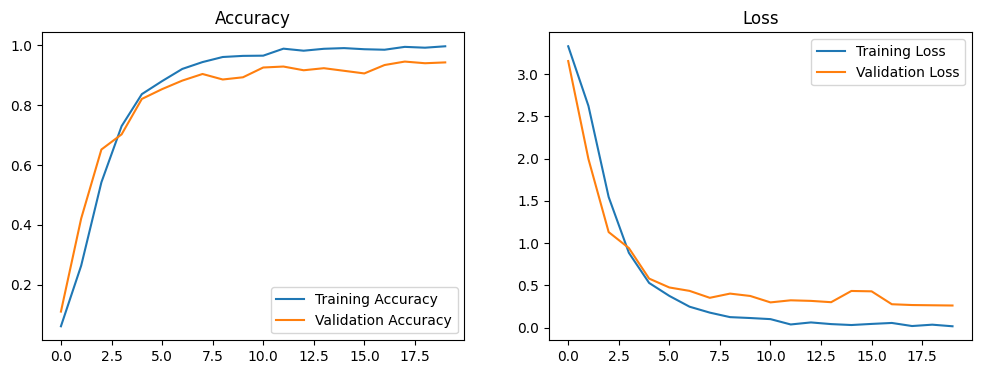

2175/2175 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step
Accuracy: 0.944367816091954
Precision: 0.9461040766165825
Recall (Sensitivity): 0.944367816091954


In [ ]:
# @title Melhores Hiperparametros SEM Dropout


# Define the model with specified hyperparameters
def build_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(CFG.img_height, CFG.img_width, CFG.img_channels)))
    for _ in range(6):  # 6 convolutional layers
        model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform'))
    model.add(MaxPooling2D((2, 2)))
    for _ in range(2):  # 2 max pooling layers
        model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(256, activation='relu', kernel_initializer='he_uniform')) # 256 neurons

    model.add(Dense(29, activation='softmax'))

    opt = SGD(learning_rate=0.0028074, momentum=0.9) # learning rate
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# ... (rest of your code, including data loading and preprocessing)

steps_per_epoch = len(train_generator)
validation_steps = len(validation_generator)

# Build and train the model
model = build_model()
history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=CFG.epochs,
    validation_data=validation_generator,
    validation_steps=validation_steps,
)


# Plotting training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')
plt.show()

predictions = model.predict(test_generator)
y_pred = np.argmax(predictions, axis=1)

# Get true labels
y_true = test_generator.classes

# Calculate metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted') # Use 'weighted' for multi-class
recall = recall_score(y_true, y_pred, average='weighted')     # Use 'weighted' for multi-class
conf_matrix = confusion_matrix(y_true, y_pred)


print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall (Sensitivity): {recall}")

Epoch 1/20
159/159 ━━━━━━━━━━━━━━━━━━━━ 26s 142ms/step - accuracy: 0.0327 - loss: 3.4640 - val_accuracy: 0.0680 - val_loss: 3.3465
Epoch 2/20
159/159 ━━━━━━━━━━━━━━━━━━━━ 33s 103ms/step - accuracy: 0.0583 - loss: 3.3302 - val_accuracy: 0.1457 - val_loss: 3.1007
Epoch 3/20
159/159 ━━━━━━━━━━━━━━━━━━━━ 16s 102ms/step - accuracy: 0.1480 - loss: 3.0625 - val_accuracy: 0.3218 - val_loss: 2.4111
Epoch 4/20
159/159 ━━━━━━━━━━━━━━━━━━━━ 16s 101ms/step - accuracy: 0.2792 - loss: 2.4619 - val_accuracy: 0.4699 - val_loss: 1.7859
Epoch 5/20
159/159 ━━━━━━━━━━━━━━━━━━━━ 16s 99ms/step - accuracy: 0.4167 - loss: 1.9508 - val_accuracy: 0.6276 - val_loss: 1.3421
Epoch 6/20
159/159 ━━━━━━━━━━━━━━━━━━━━ 21s 99ms/step - accuracy: 0.5393 - loss: 1.4847 - val_accuracy: 0.7067 - val_loss: 1.0223
Epoch 7/20
159/159 ━━━━━━━━━━━━━━━━━━━━ 17s 104ms/step - accuracy: 0.6077 - loss: 1.2409 - val_accuracy: 0.7536 - val_loss: 0.8504
Epoch 8/20
159/159 ━━━━━━━━━━━━━━━━━━━━ 20s 100ms/step - accuracy: 0.6866 - loss: 0.9

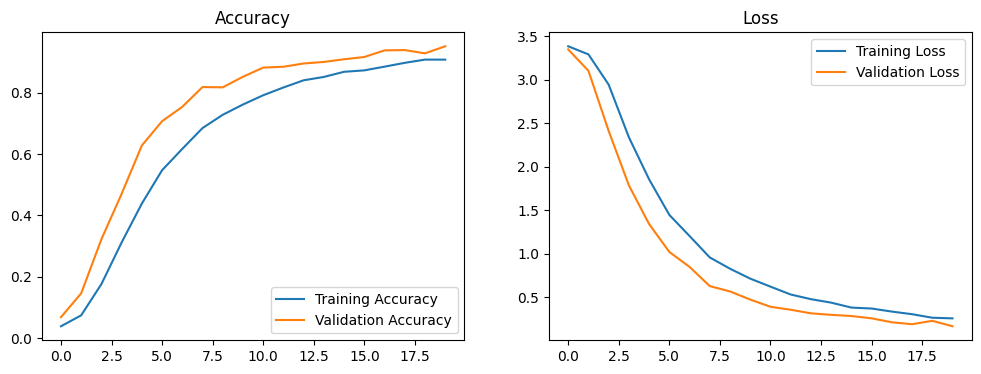

2175/2175 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step


In [ ]:
# @title Melhores Hiperparametros COM Dropout

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import SGD
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
import seaborn as sns

# Define the model with specified hyperparameters
def build_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(CFG.img_height, CFG.img_width, CFG.img_channels)))
    for _ in range(6):
        model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform'))
    model.add(MaxPooling2D((2, 2)))
    for _ in range(2):
        model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(256, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dropout(0.5))
    model.add(Dense(29, activation='softmax'))

    opt = SGD(learning_rate=0.0028074, momentum=0.9)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model


steps_per_epoch = len(train_generator)
validation_steps = len(validation_generator)

# Build and train the model
model = build_model()
history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=CFG.epochs,
    validation_data=validation_generator,
    validation_steps=validation_steps,
)


# Plotting training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')
plt.show()

In [ ]:
predictions = model.predict(test_generator)
y_pred = np.argmax(predictions, axis=1)

# Get true labels
y_true = test_generator.classes

# Calculate metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted') # Use 'weighted' for multi-class
recall = recall_score(y_true, y_pred, average='weighted')     # Use 'weighted' for multi-class
conf_matrix = confusion_matrix(y_true, y_pred)


print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall (Sensitivity): {recall}")

2175/2175 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step
Accuracy: 0.9452873563218391
Precision: 0.9461999686018377
Recall (Sensitivity): 0.9452873563218391


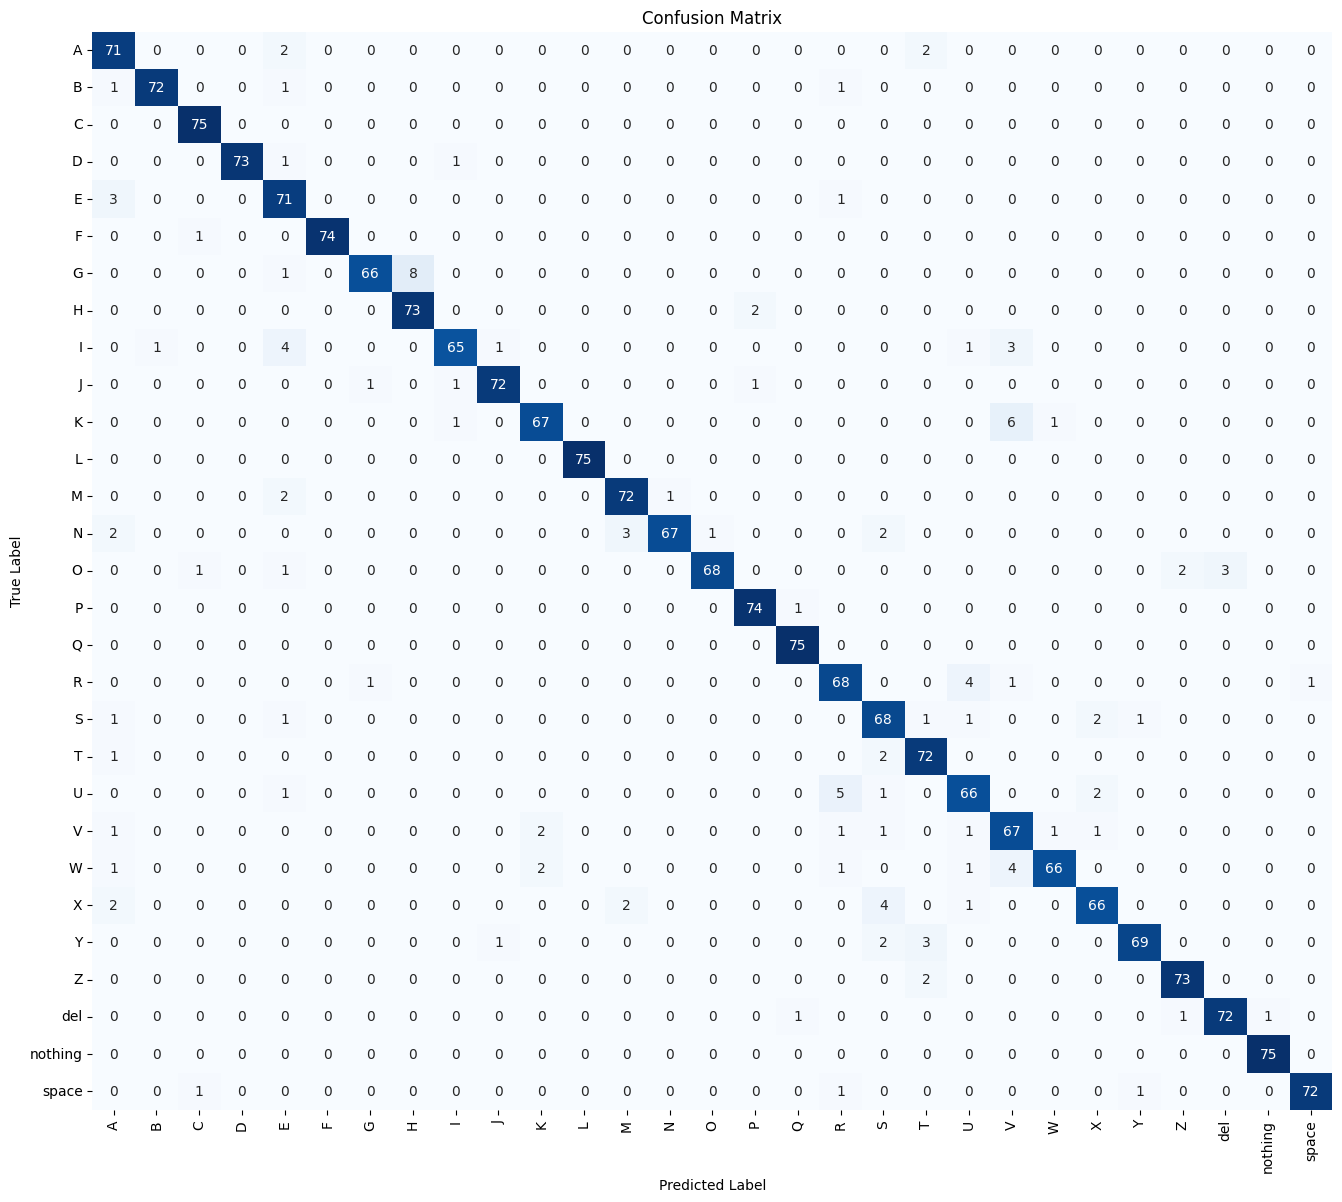

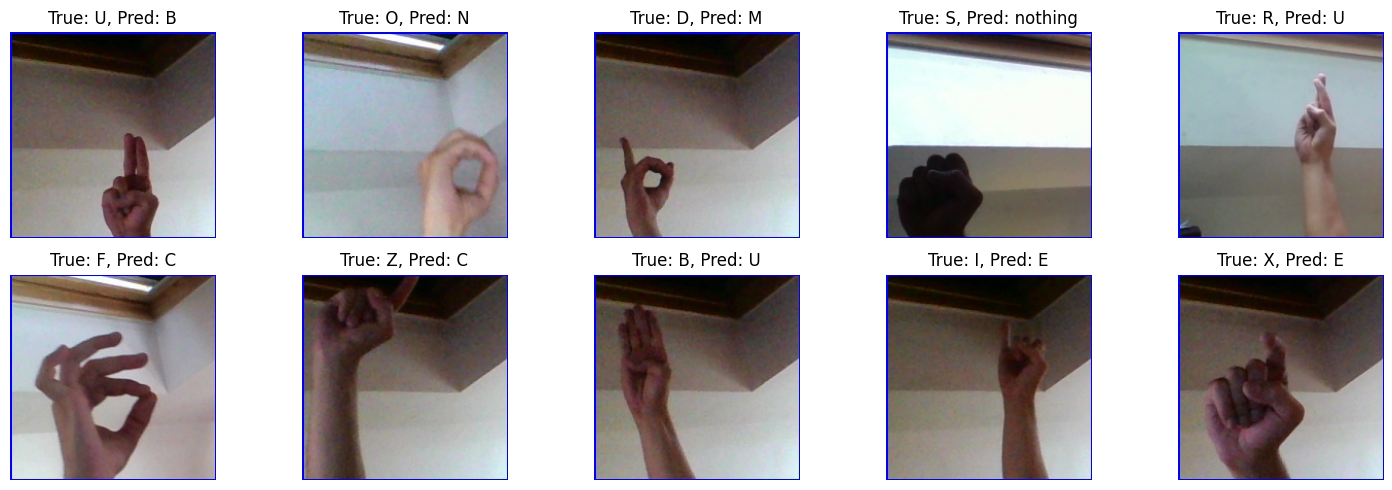

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
import numpy as np


plt.figure(figsize=(16, 14))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


# Displaying misclassified images
misclassified_indices = np.where(y_true != y_pred)[0]
num_misclassified = len(misclassified_indices)

num_images_to_display = min(num_misclassified, 10)


plt.figure(figsize=(15, 5))
for i in range(num_images_to_display):
  index = misclassified_indices[i]
  image_path = data_test.iloc[index]['image_path']
  img = plt.imread(image_path)
  plt.subplot(2, 5, i+1)
  plt.imshow(img)
  plt.title(f"True: {labels[y_true[index]]}, Pred: {labels[y_pred[index]]}")
  plt.axis('off')

plt.tight_layout()
plt.show()




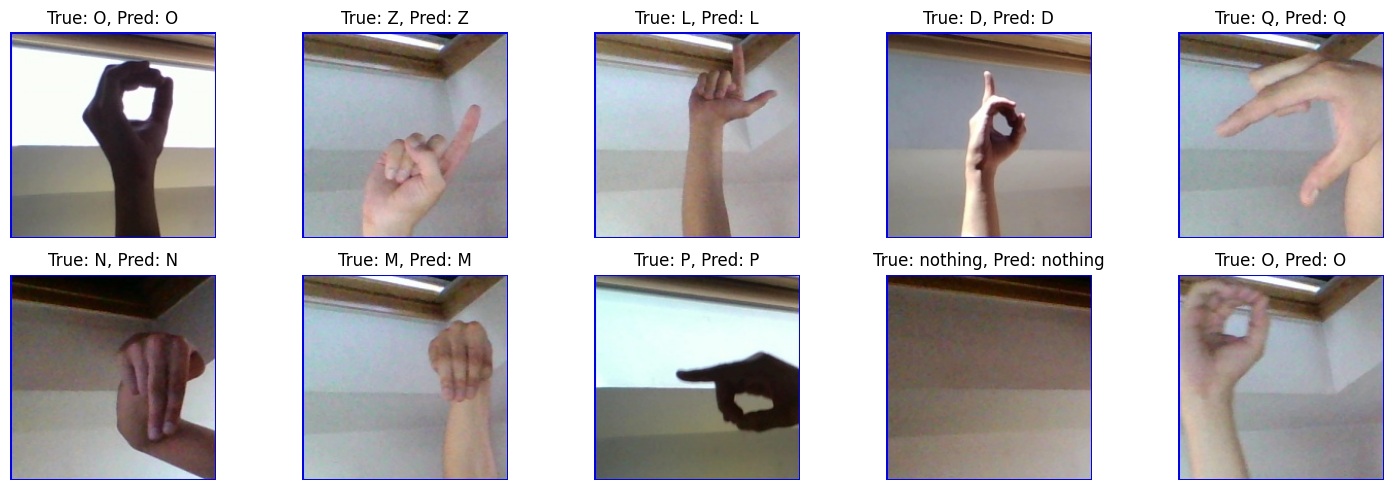

In [ ]:
corrclassified_indices = np.where(y_true == y_pred)[0]
num_corrclassified = len(corrclassified_indices)
num_images_to_display2 = min(num_corrclassified, 10)

plt.figure(figsize=(15, 5))
for i in range(num_images_to_display2):
  index = corrclassified_indices[i]
  image_path = data_test.iloc[index]['image_path']
  img = plt.imread(image_path)
  plt.subplot(2, 5, i+1)
  plt.imshow(img)
  plt.title(f"True: {labels[y_true[index]]}, Pred: {labels[y_pred[index]]}")
  plt.axis('off')

plt.tight_layout()
plt.show()


#3. | Transfer Learning

3.1. VGG16


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 64, 64, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 32, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 16, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 16, 16, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 16, 16, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 8, 8, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 2, 2, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 29)             │         7,453 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,246,685 (58.16 MB)

 Trainable params: 531,997 (2.03 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

None

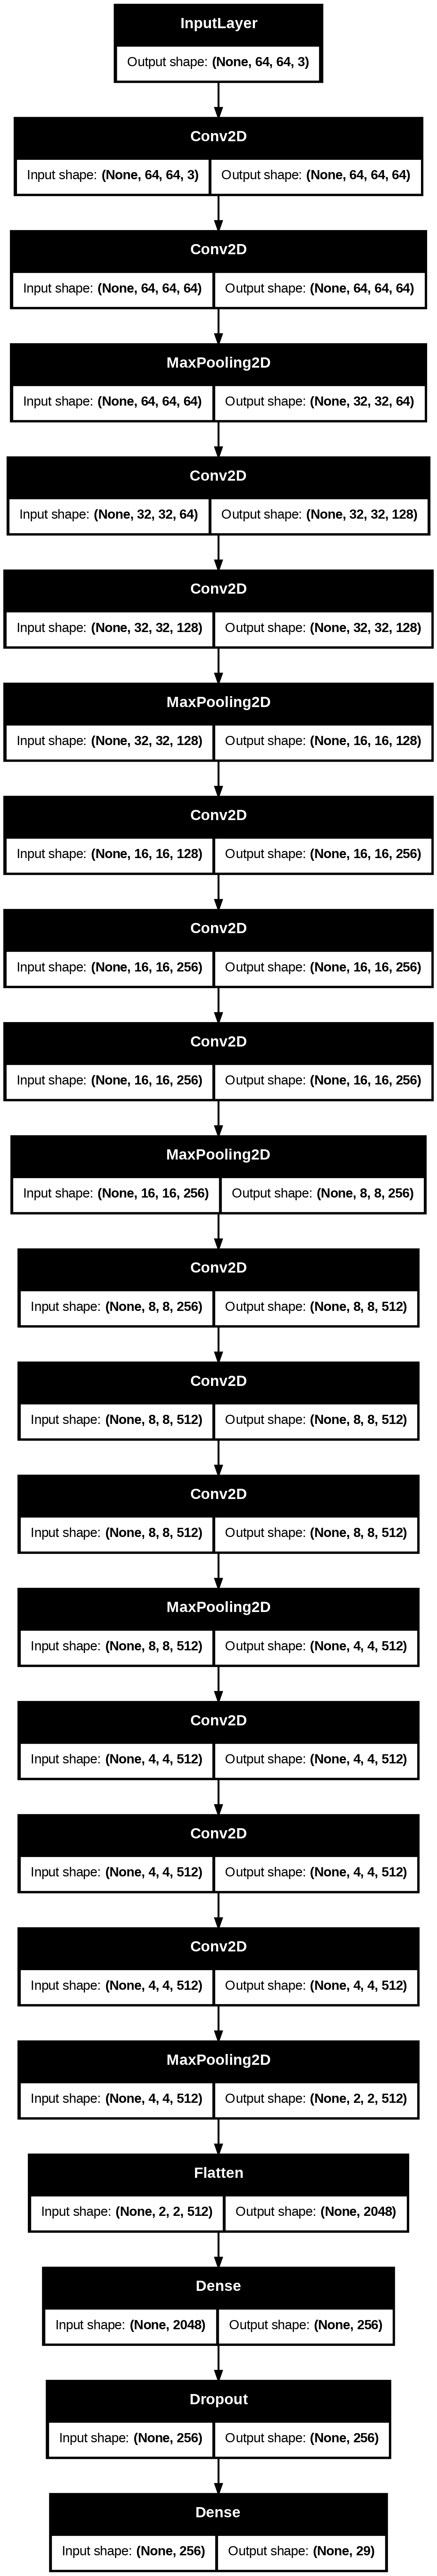

In [ ]:
# Load VGG16 model and modify for ASL recognition
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(CFG.img_height, CFG.img_width, CFG.img_channels))

for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(29, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

display(model.summary())
display(tf.keras.utils.plot_model(model, to_file='vgg16.png', show_shapes=True))

<div>
    <h2 style = "color: #c7a48b; font-size: 22px; font-family: Calibri; font-weight: bold;">3.2. Training</h2>
</div>

In [ ]:
# Compile and train the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
checkpoint = ModelCheckpoint('/content/asl_vgg16_best_weights.h5', save_best_only=True, monitor='val_accuracy', mode='max')

In [ ]:
# Train the Model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // CFG.batch_size,
    epochs=CFG.epochs,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // CFG.batch_size,
    callbacks=[checkpoint]
)

Epoch 1/20
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step - accuracy: 0.2239 - loss: 2.8554

158/158 ━━━━━━━━━━━━━━━━━━━━ 58s 317ms/step - accuracy: 0.2247 - loss: 2.8522 - val_accuracy: 0.7429 - val_loss: 1.3521
Epoch 2/20
158/158 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.5156 - loss: 1.6122 - val_accuracy: 0.7306 - val_loss: 1.3490
Epoch 3/20
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.6027 - loss: 1.4039

158/158 ━━━━━━━━━━━━━━━━━━━━ 39s 96ms/step - accuracy: 0.6030 - loss: 1.4030 - val_accuracy: 0.8187 - val_loss: 0.8086
Epoch 4/20
  1/158 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.7812 - loss: 0.8626

158/158 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.7812 - loss: 0.8626 - val_accuracy: 0.8253 - val_loss: 0.8012
Epoch 5/20
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.7263 - loss: 0.9510

158/158 ━━━━━━━━━━━━━━━━━━━━ 15s 97ms/step - accuracy: 0.7264 - loss: 0.9506 - val_accuracy: 0.8868 - val_loss: 0.5792
Epoch 6/20
  1/158 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.7344 - loss: 0.9290

158/158 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.7344 - loss: 0.9290 - val_accuracy: 0.8911 - val_loss: 0.5718
Epoch 7/20
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.7841 - loss: 0.7453

158/158 ━━━━━━━━━━━━━━━━━━━━ 20s 114ms/step - accuracy: 0.7842 - loss: 0.7450 - val_accuracy: 0.9115 - val_loss: 0.4215
Epoch 8/20
158/158 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.8594 - loss: 0.5412 - val_accuracy: 0.9100 - val_loss: 0.4196
Epoch 9/20
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.8306 - loss: 0.5893

158/158 ━━━━━━━━━━━━━━━━━━━━ 21s 130ms/step - accuracy: 0.8306 - loss: 0.5891 - val_accuracy: 0.9290 - val_loss: 0.3505
Epoch 10/20
  1/158 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - accuracy: 0.8594 - loss: 0.4595

158/158 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.8594 - loss: 0.4595 - val_accuracy: 0.9309 - val_loss: 0.3514
Epoch 11/20
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.8556 - loss: 0.5004

158/158 ━━━━━━━━━━━━━━━━━━━━ 41s 162ms/step - accuracy: 0.8556 - loss: 0.5003 - val_accuracy: 0.9380 - val_loss: 0.2915
Epoch 12/20
  1/158 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.9062 - loss: 0.2821

158/158 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.9062 - loss: 0.2821 - val_accuracy: 0.9399 - val_loss: 0.2886
Epoch 13/20
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.8773 - loss: 0.4249

158/158 ━━━━━━━━━━━━━━━━━━━━ 28s 95ms/step - accuracy: 0.8773 - loss: 0.4248 - val_accuracy: 0.9432 - val_loss: 0.2567
Epoch 14/20
  1/158 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.9531 - loss: 0.2555

158/158 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.9531 - loss: 0.2555 - val_accuracy: 0.9465 - val_loss: 0.2476
Epoch 15/20
158/158 ━━━━━━━━━━━━━━━━━━━━ 18s 97ms/step - accuracy: 0.8894 - loss: 0.3813 - val_accuracy: 0.9460 - val_loss: 0.2347
Epoch 16/20
  1/158 ━━━━━━━━━━━━━━━━━━━━ 6s 41ms/step - accuracy: 0.8750 - loss: 0.4909

158/158 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - accuracy: 0.8750 - loss: 0.4909 - val_accuracy: 0.9479 - val_loss: 0.2272
Epoch 17/20
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.9025 - loss: 0.3412

158/158 ━━━━━━━━━━━━━━━━━━━━ 16s 98ms/step - accuracy: 0.9025 - loss: 0.3411 - val_accuracy: 0.9527 - val_loss: 0.2025
Epoch 18/20
158/158 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.9219 - loss: 0.3039 - val_accuracy: 0.9517 - val_loss: 0.2023
Epoch 19/20
158/158 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.9149 - loss: 0.3012

158/158 ━━━━━━━━━━━━━━━━━━━━ 15s 95ms/step - accuracy: 0.9148 - loss: 0.3012 - val_accuracy: 0.9569 - val_loss: 0.1747
Epoch 20/20
158/158 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.9531 - loss: 0.1987 - val_accuracy: 0.9555 - val_loss: 0.1797


<div style = "color: Black;
              display: fill;
              border-radius: 12px;
              background-color: #c7a48b;
              box-shadow: rgba(0, 0, 0, 0.15) 0px 10px 5px, rgba(0, 0, 0, 0.12) 0px 6px 6px;">
    <h1 id = "model-evaluation"
        style = "padding: 13px;
                 color: White;
                 font-size: 24px;
                 font-weight: bold;
                 font-family: Calibri;">4. | Model Evaluation
    </h1>
</div>

<div>
    <h2 style = "color: #c7a48b; font-size: 22px; font-family: Calibri; font-weight: bold;">4.1. Model Testing</h2>
</div>

In [ ]:
# Get predictions
predictions = model.predict(test_generator)
y_pred = np.argmax(predictions, axis=1)

# Get true labels
y_true = test_generator.classes

2175/2175 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step


In [ ]:
scores = model.evaluate(test_generator)
print("%s: %.2f%%" % ("Evaluate Test Accuracy", scores[1]*100))

2175/2175 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - accuracy: 0.9489 - loss: 0.2040
Evaluate Test Accuracy: 94.99%


<div>
    <h2 style = "color: #c7a48b; font-size: 22px; font-family: Calibri; font-weight: bold;">4.2. Training Loss and Metrics</h2>
</div>

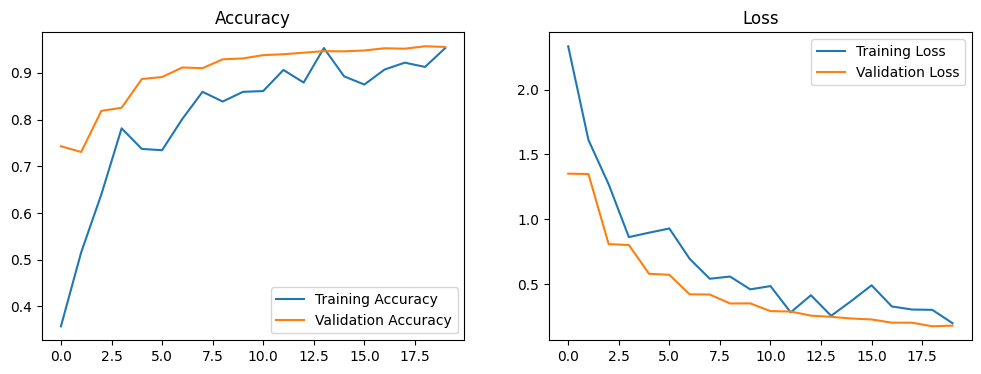

In [ ]:
# Plotting training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')
plt.show()

<div>
    <h2 style = "color: #c7a48b; font-size: 22px; font-family: Calibri; font-weight: bold;">4.3. Confusion Matrix</h2>
</div>

Accuracy: 0.9498850574712644
Precision: 0.9526370440560243
Recall (Sensitivity): 0.9498850574712644


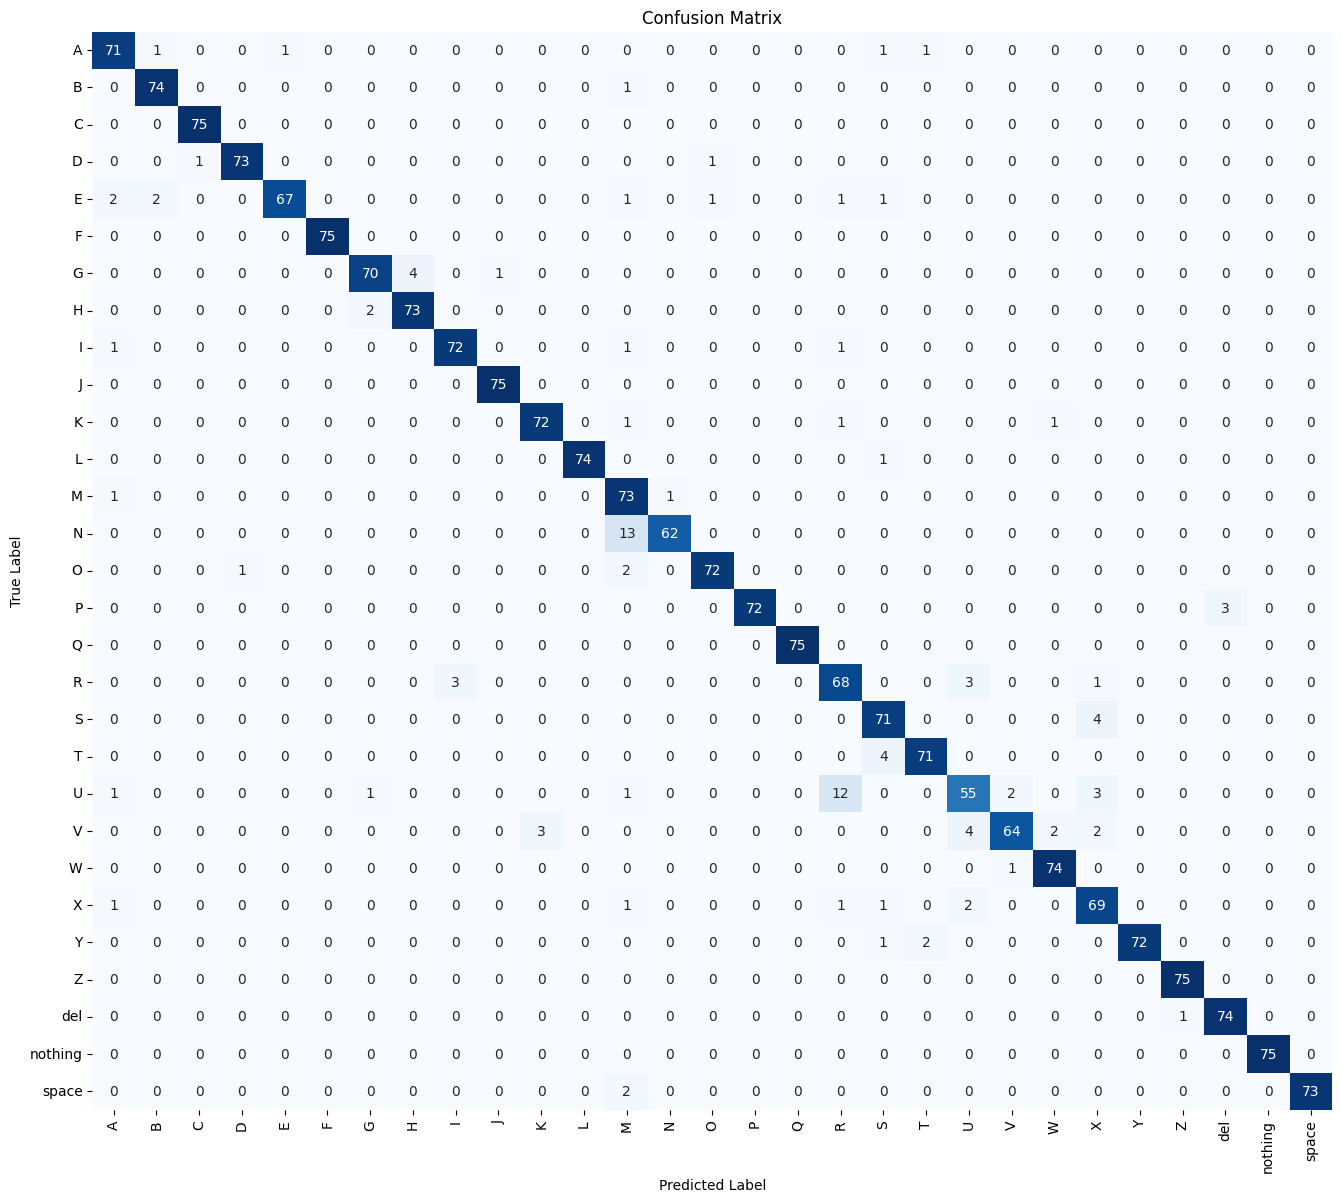

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix


accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')

conf_matrix = confusion_matrix(y_true, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall (Sensitivity): {recall}")


plt.figure(figsize=(16, 14))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


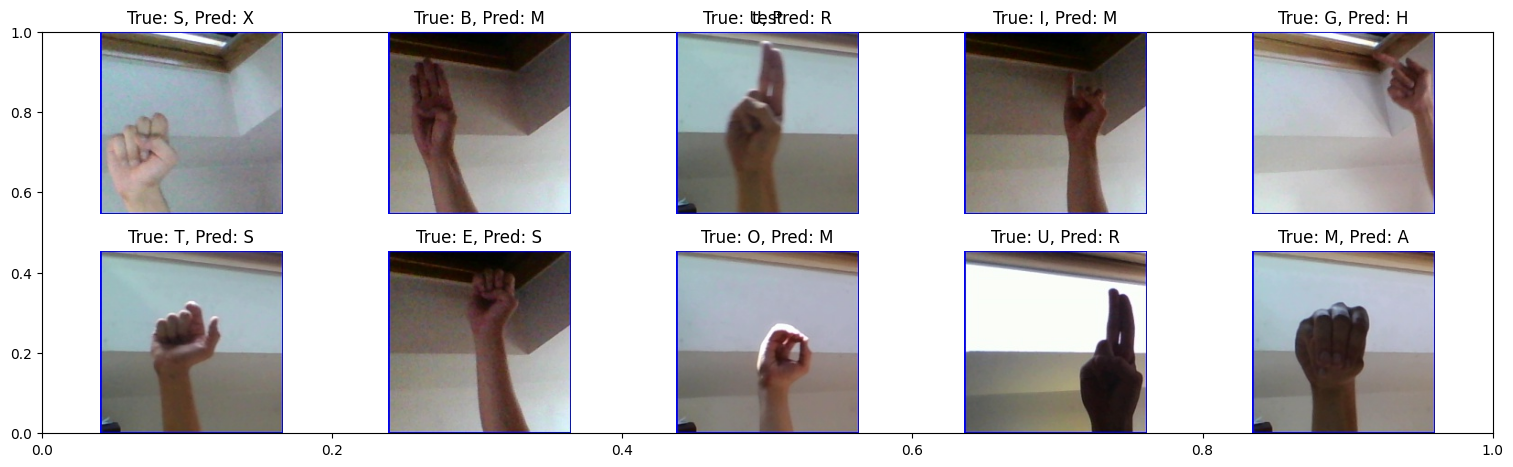

In [ ]:
# @title Misclassified images
misclassified_indices = np.where(y_true != y_pred)[0]
num_misclassified = len(misclassified_indices)

# Display some misclassified images
num_images_to_display = min(num_misclassified, 10)

plt.figure(figsize=(15, 5))

for i in range(num_images_to_display):
  index = misclassified_indices[i]
  image_path = data_test.iloc[index]['image_path']
  img = plt.imread(image_path)
  plt.subplot(2, 5, i+1)
  plt.imshow(img)
  plt.title(f"True: {labels[y_true[index]]}, Pred: {labels[y_pred[index]]}")
  plt.axis('off')

plt.tight_layout()
plt.show()

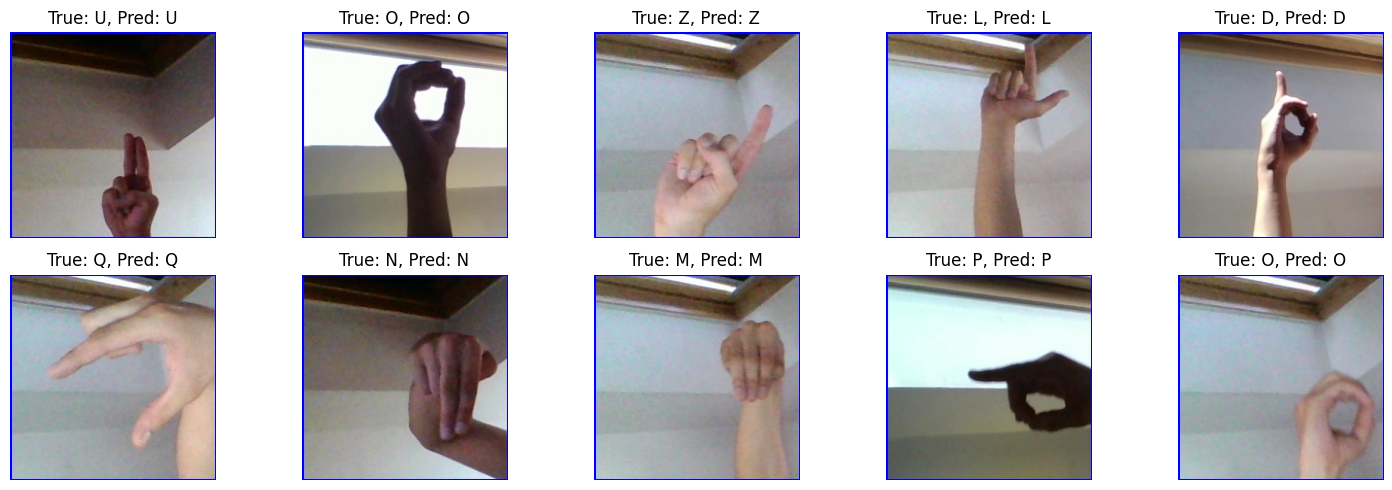

In [ ]:
# @title Correctly classified images

corrclassified_indices = np.where(y_true == y_pred)[0]
num_corrclassified = len(corrclassified_indices)
num_images_to_display2 = min(num_corrclassified, 10)

plt.figure(figsize=(15, 5))
for i in range(num_images_to_display2):
  index = corrclassified_indices[i]
  image_path = data_test.iloc[index]['image_path']
  img = plt.imread(image_path)
  plt.subplot(2, 5, i+1)
  plt.imshow(img)
  plt.title(f"True: {labels[y_true[index]]}, Pred: {labels[y_pred[index]]}")
  plt.axis('off')

plt.tight_layout()
plt.show()
